<a href="https://colab.research.google.com/github/sadat1971/Deep_Learning_NLP/blob/main/Sentiment_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Sentence Classification using BERT model

This step-by-step notebook will show the implementation of BERT model to classify sentiment classification. The code is inspired from the [awesome blog](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) of Jay Alammar.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 10.4MB/s 
     |████████████████████████████████| 890kB 30.9MB/s 
     |████████████████████████████████| 2.9MB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c3d7af62633f5aac626b1d8f48bd905f451c76209c4ba41cbb30114c489804a7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None, names=['Sentence', 'Positive_or_not'])
df.head()

,Sentence,Positive_or_not
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
# For running purpose, we take first 1.5 k of data
df = df[:1500]

In [5]:
df['Positive_or_not'].value_counts() # How many ones and zeros we have

1    782
0    718
Name: Positive_or_not, dtype: int64

In [6]:
#judging with regular words, how many words do we have per sentences?

import string

def count_words(sen):
  words_with_punc = sen.split()
  words_len = len([w for w in words_with_punc if w not in string.punctuation])
  return words_len

df['word_length'] = df['Sentence'].apply(lambda x:count_words(x))

df.head()


,Sentence,Positive_or_not,word_length
0,"a stirring , funny and finally transporting re...",1,17
1,apparently reassembled from the cutting room f...,0,12
2,they presume their audience wo n't sit still f...,0,34
3,this is a visually stunning rumination on love...,1,17
4,jonathan parker 's bartleby should have been t...,1,18


In [7]:
df.word_length.describe()

count    1500.000000
mean       18.150000
std         8.952221
min         1.000000
25%        11.000000
50%        18.000000
75%        25.000000
max        48.000000
Name: word_length, dtype: float64

Now that we know a little bit about our dataset, let's load the distillbert model and the tokenizer 

In [8]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [9]:
# Let's tokenize the sentences so that we can use them as an input to out BERT model
import time
start_time = time.time()
tokenized = df['Sentence'].apply(lambda x:tokenizer.encode(x, add_special_tokens=True))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.796076774597168 seconds ---


In [10]:
tokenized  #We have the tokenized-id representation of every tokens in the sentences

0       [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1       [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2       [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3       [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4       [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
                              ...                        
1495    [101, 2498, 2062, 2084, 1037, 15536, 24291, 27...
1496    [101, 2919, 1998, 8670, 4246, 2989, 2013, 1996...
1497    [101, 1996, 27885, 3630, 25171, 2569, 3896, 10...
1498    [101, 1996, 16587, 3046, 2000, 5703, 4197, 101...
1499                              [101, 19741, 4569, 102]
Name: Sentence, Length: 1500, dtype: object

tokenized is simply a pandas series with list of different shapes. To make a bunoy array, we need to do the following steps

1. Find the maximum length of tokens in all the sentences
2. pad zero to the end of the tokens upto untill the maximum value

In [11]:
max_len = max([len(t) for t in tokenized.values]) #find maximum

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values]) #pad zero

In [12]:
padded.shape

(1500, 59)

In [13]:
padded

array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  1996, 27885, ...,     0,     0,     0],
       [  101,  1996, 16587, ...,     0,     0,     0],
       [  101, 19741,  4569, ...,     0,     0,     0]])

**GREAT!** Now the problem is, BERT will still have a hard time unless it knows which values are to be 'ignored'. Let's help BERT by building the attention mask

In [14]:
attention_mask = np.where(padded != 0, 1, 0) #it means, put 1 where the condition padded!=0 satisfies, and 0 where it doesn't
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

Next, we will run the data through the pretrained model. The process roughly takes 87 seconds per 1000 sentences. Also, donot load more than 2k words with the basic colab version to avoid RAM being crashed.

In [18]:
#First, convert the numpy array to tensor
input_ids = torch.tensor(padded)  
#convert the attention mask array to tensor
attention_mask = torch.tensor(attention_mask)
start_time=time.time()
with torch.no_grad(): #we donot need the backprop here
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
print("--- %s seconds ---" % (time.time() - start_time))

--- 128.46458077430725 seconds ---


In [19]:
last_hidden_states[0].shape

torch.Size([1500, 59, 768])

In [20]:
print(last_hidden_states[0][:,0,:])

tensor([[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
        [-0.1726, -0.1448,  0.0022,  ..., -0.1744,  0.2139,  0.3720],
        [-0.0506,  0.0720, -0.0296,  ..., -0.0715,  0.7185,  0.2623],
        ...,
        [ 0.0062,  0.0426, -0.1080,  ..., -0.0417,  0.6836,  0.3451],
        [ 0.0087,  0.0605, -0.3309,  ..., -0.2005,  0.6268,  0.1546],
        [-0.2395, -0.1362,  0.0463,  ..., -0.0285,  0.2219,  0.3242]])


In [21]:
features = last_hidden_states[0][:,0,:]
features_np = features.numpy()

In [23]:
np.save('feat.npy', features_np)

In [24]:

from google.colab import files
files.download("feat.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Alternatively, if you have saved the last_hidden_state (let's say, as **features.npy**), then you can load that as well with the following code.

In [15]:
from google.colab import files
files.upload()
features = np.load("feat.npy")

Saving feat.npy to feat.npy


In [16]:
labels = list(df['Positive_or_not'])

In [17]:
features.shape

(1500, 768)

In [18]:
len(labels)

1500

We will use feedforward neural net for the classification task

In [19]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [21]:
# let's batch them first
#  For making the batches
class PrepareData(Dataset):

    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X 
        if not torch.is_tensor(y):
            self.y = torch.tensor(y)
        else:
            self.y = y 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
class feeforwardnet(torch.nn.Module):

  def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, dropout):
    super(feeforwardnet, self).__init__()
    # #self.network = nn.Sequential(nn.Linear(input_size, hidden_size_1),
    #                              nn.ReLU(),
    #                              nn.Linear(hidden_size_1, hidden_size_2),
    #                              nn.Relu(),
    #                              nn.Linear(hidden_size_2, output_size),
    #                              nn.Softmax())
    self.fc1 = (nn.Linear(input_size, hidden_size_1))
    #torch.nn.init.xavier_normal_(self.fc1.weight)
    #self.fc2 =(nn.Linear(hidden_size_1, hidden_size_2))
    self.fc3 = (nn.Linear(hidden_size_1, output_size))
    self.soft = nn.Softmax()
    self.dout = dropout
    
  def forward(self, X):
    X = F.relu(self.fc1(X))
    X = nn.Dropout(self.dout)(X)
    # X = F.relu(self.fc2(X))
    # X = nn.Dropout(self.dout)(X)
    X = F.relu(self.fc3(X))
    X = self.soft(X)
    return X


In [23]:
def training_and_CV(X, Y, h1, h2, epoch=100, batchsize=512, lr=0.01, dout=0.3):

  #clarify the train-cv split to avoid overfit
  X_tr, X_CV, Y_tr, Y_CV = train_test_split(X, Y, test_size=0.1, random_state=42)
  X_tr, X_CV, Y_tr, Y_CV = map(torch.tensor, (X_tr, X_CV, Y_tr, Y_CV))
  #create the batches
  ds = PrepareData(X=X_tr, y=Y_tr)
  dats = DataLoader(ds, batch_size=batchsize, shuffle=True)
  model = feeforwardnet(X_tr.shape[1], h1, h2, 2, dout)
  optim = torch.optim.SGD(model.parameters(), lr=lr)
  LOSS_LIST = []
  train_loss = []
  CV_loss = []

  for e in range(epoch):
    for idx, (X_batch, y_batch) in enumerate(dats):
      #model after forward pass is model(X_batch)
      loss = F.cross_entropy(model(X_batch.float()), y_batch)

      #model of the backward pass:
      optim.zero_grad()
      loss.backward()
      optim.step()

    train_loss.append(F.cross_entropy(model(X_tr.float()), Y_tr))
    CV_loss.append(F.cross_entropy(model(X_CV.float()), Y_CV))
    if e%100==0:
      print("For epoch {}, train loss is {}, and CV loss is {}".format(e, F.cross_entropy(model(X_tr.float()), Y_tr), F.cross_entropy(model(X_CV.float()), Y_CV)))

  plt.figure(figsize=(50, 10))
  plt.plot(list(range(epoch)), train_loss, 'g', label='train')
  plt.plot(list(range(epoch)), CV_loss, 'r', label='CV')
  plt.legend()
  plt.show()

  model.eval()

  return model(X_tr), Y_tr, model(X_CV), Y_CV

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


For epoch 0, train loss is 0.692298412322998, and CV loss is 0.6873891353607178
For epoch 100, train loss is 0.4729251563549042, and CV loss is 0.5212796330451965


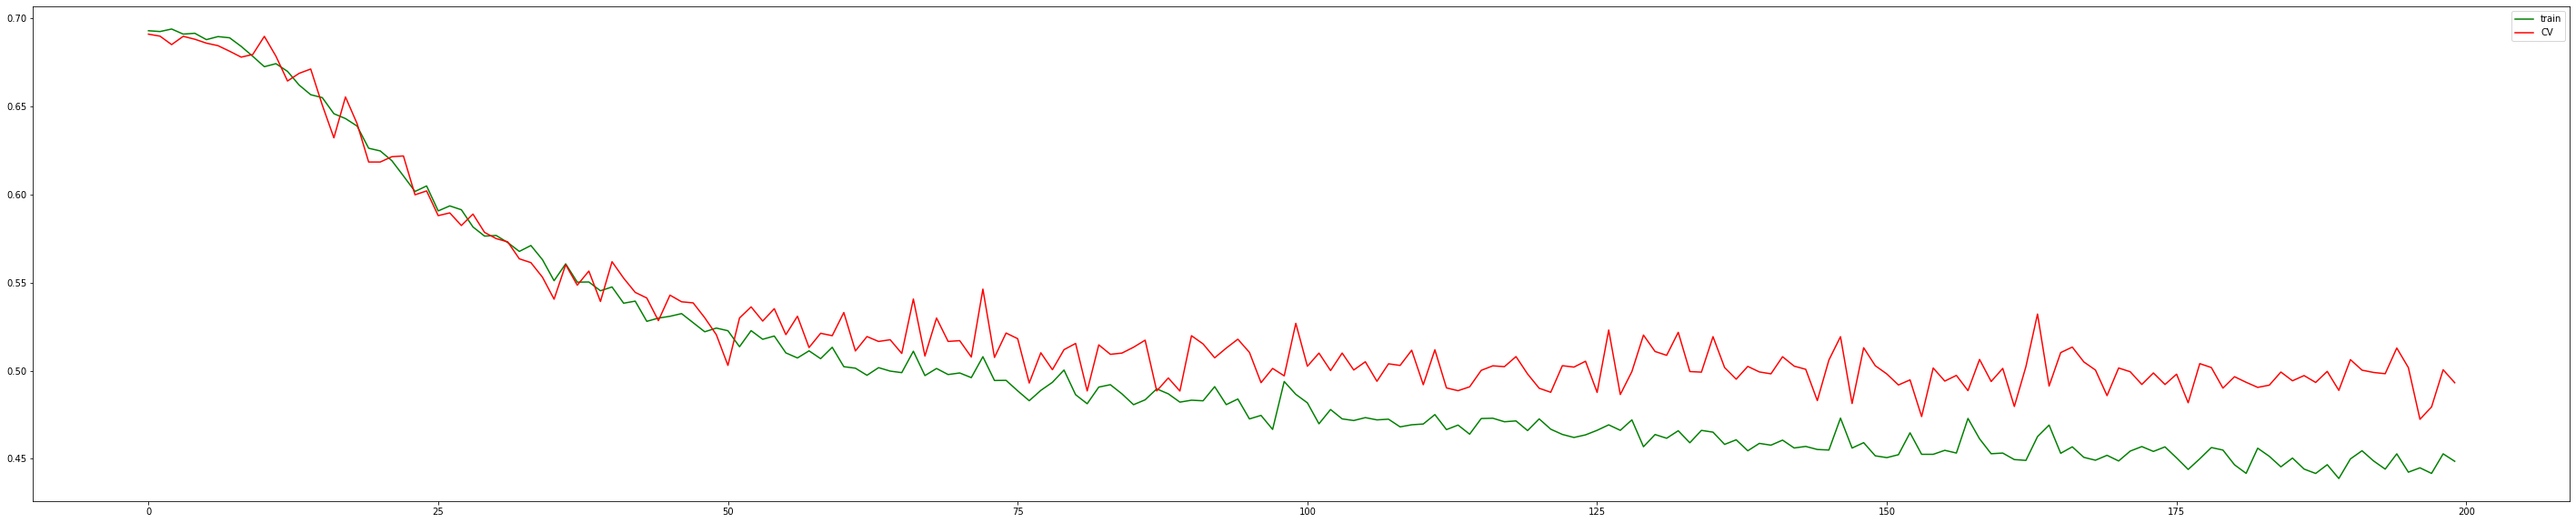

In [28]:
train_result, train_label, CV_result, CV_label = training_and_CV(X_train, y_train, epoch=200, h1=128, h2=128, batchsize=16,  lr=0.01, dout=0.7)

In [29]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  if not torch.is_tensor(y):
    y = torch.tensor(y)
  return (pred == y).float().mean()

In [30]:
accuracy(CV_result, CV_label)

tensor(0.8222)

In [31]:
accuracy(train_result, train_label)

tensor(0.8765)

In [37]:
start_time = time.time()
torch.manual_seed(0)
final_net = feeforwardnet(X_train.shape[1], hidden_size_1=128, hidden_size_2=2, output_size=2, dropout=0.7)
X_train, y_train = map(torch.tensor, (X_train, y_train))
#create the batches
ds = PrepareData(X=X_train, y=y_train)
dats = DataLoader(ds, batch_size=8, shuffle=True)
optim = torch.optim.SGD(final_net.parameters(), lr=0.01)

for e in range(1000):
  for idx, (X_batch, y_batch) in enumerate(dats):
    #model after forward pass is model(X_batch)
    loss = F.cross_entropy(final_net(X_batch.float()), y_batch)

    #model of the backward pass:
    optim.zero_grad()
    loss.backward()
    optim.step()
  if e%100==1:
    model_loss = F.cross_entropy(final_net(X_train.float()), y_train)
    print("for epoch {} is, model loss is {}".format(e, model_loss))

time.time() - start_time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


for epoch 1 is, model loss is 0.6932197213172913
for epoch 101 is, model loss is 0.4593735635280609
for epoch 201 is, model loss is 0.43284234404563904
for epoch 301 is, model loss is 0.4240082800388336
for epoch 401 is, model loss is 0.41203048825263977
for epoch 501 is, model loss is 0.4038241505622864
for epoch 601 is, model loss is 0.38598665595054626
for epoch 701 is, model loss is 0.3959333002567291
for epoch 801 is, model loss is 0.3797290027141571
for epoch 901 is, model loss is 0.373735249042511


177.94285011291504

In [68]:
final_net.eval()

feeforwardnet(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (soft): Softmax(dim=None)
)

In [69]:
print("Train accuracy is ", accuracy(final_net(X_train), y_train))

Train accuracy is  tensor(0.9556)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [70]:
print("Test accuracy is ", accuracy(final_net(torch.tensor(X_test)), y_test))

Test accuracy is  tensor(0.8133)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Let's compare the accuracy with Logistic regression model

In [43]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("train accuracy is ", lr.score(X_train, y_train))
print("test accuracy is ", lr.score(X_test, y_test))

train accuracy is  0.9155555555555556
test accuracy is  0.8066666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
